# Início

Importações e leituras dos dados

In [ ]:
#IMPORTACOES
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
#import tensorflow as tf
import random
import plotly.figure_factory as ff
import copy

In [ ]:
#Concetando com o Google Drive para ler os dados
from google.colab import drive
drive.mount('/content/drive')

#salva o diretório dentro do Google Drive com as imagens
dataset_a = "/content/drive/MyDrive/Colab Notebooks/IC/a_an_example.in.txt"
dataset_b = "/content/drive/MyDrive/Colab Notebooks/IC/b_better_start_small.in.txt"
dataset_c = "/content/drive/MyDrive/Colab Notebooks/IC/c_collaboration.in.txt"
dataset_d = "/content/drive/MyDrive/Colab Notebooks/IC/d_dense_schedule.in.txt"
dataset_e = "/content/drive/MyDrive/Colab Notebooks/IC/e_exceptional_skills.in.txt"
dataset_f = "/content/drive/MyDrive/Colab Notebooks/IC/f_find_great_mentors.in.txt"

Mounted at /content/drive


# Leitura dos dados

Transformação para dicionários (maps) para

In [ ]:
def read_dataset(file_path):
    test_dataset = {
        'contributors': {},
        'projects': {},
    }
    num_c = None
    num_p = None

    with open(file_path, 'r') as file:
        lines = file.readlines()

    i = 0
    while i < len(lines):

        if i==0:
          line = lines[i].strip().split()
          num_c = int(line[0])
          num_p = int(line[0])+int(line[1])

        elif i<=num_c:
            line = lines[i].strip().split()
            contributor_name = line[0]
            contributor_numSkills = int(line[1])

            test_dataset['contributors'][contributor_name] = {
                'name': contributor_name,
                'skills': [],
                'skillsByName': {},
                'availableAt' : 0,
                'works': 0
            }

            for j in range(contributor_numSkills):
              i += 1
              num_c+=1
              num_p+=1
              line = lines[i].strip().split()

              skills = {'name': line[0], 'level': int(line[1])}
              skillsBN = {line[0] : int(line[1])}
              test_dataset['contributors'][contributor_name]['skills'].append(skills)
              test_dataset['contributors'][contributor_name]['skillsByName'].update(skillsBN)


        elif i<=num_p:
            line = lines[i].strip().split()
            project_name = line[0]
            project_numSkills = int(line[4])

            test_dataset['projects'][project_name] = {
                'name': project_name,
                'days': int(line[1]),
                'score': int(line[2]),
                'bestBefore': int(line[3]),
                'roles': [],
                'rolesByName': {}
            }

            for j in range(project_numSkills):
              i += 1
              num_c+=1
              num_p+=1
              line = lines[i].strip().split()

              roles = {'name': line[0], 'levelRequired': int(line[1])}
              rolesBN = {line[0] : int(line[1])}
              test_dataset['projects'][project_name]['roles'].append(roles)
              test_dataset['projects'][project_name]['rolesByName'].update(rolesBN)

        i += 1
    return test_dataset

dataset_A = read_dataset(dataset_a)
dataset_B = read_dataset(dataset_b)
dataset_C = read_dataset(dataset_c)
dataset_D = read_dataset(dataset_d)
dataset_E = read_dataset(dataset_e)
dataset_F = read_dataset(dataset_f)

# Solver

Função para resolver o dataset

Parâmetros:
dataset: conjuntos de dados para serem resolvidos \\
priority_order: heurística da ordem dos projetos \\
contributor_order: heurística das ordem dos contribuidores \\
flag_print: valor binário para indicar se vai mostrar os gráficos

In [ ]:
# Pega uma variável de conjunto de dados e retorna uma variável de solução
def solve(dataset, priority_order, contributor_order, flag_print):
    plotx = [ 0 ]
    ploty = [ len(dataset['projects'].values()) ]
    for contributor in dataset['contributors'].values():
        contributor['availableAt'] = 0

    totalScore = 0
    lastDay = max(proj['bestBefore'] + proj['score'] for proj in dataset['projects'].values())

    solution = {'projects': []}
    selectedProjectNames = set()
    currentTime = 0
    projectOrder = []

    #skills_not_ok = change_values(dataset)

    if(priority_order=="SPT"):
      for project in dataset['projects'].values():
        spt = project['days']
        projectOrder.append((spt, project['name']))
      projectOrder.sort(reverse=False)

    elif(priority_order=="LPT"):
      for project in dataset['projects'].values():
        spt = project['days']
        projectOrder.append((spt, project['name']))
      projectOrder.sort(reverse=True)

    elif(priority_order=="EDD"):
      for project in dataset['projects'].values():
        edd = project['bestBefore']
        projectOrder.append((edd, project['name']))
      projectOrder.sort(reverse=False)

    elif(priority_order=="MST"):
      for project in dataset['projects'].values():
        mst = max(0, project['days'] + project['bestBefore'])
        projectOrder.append((mst, project['name']))
      projectOrder.sort(reverse=False)

    elif(priority_order=="CR"):
      for project in dataset['projects'].values():
        cr = max(0, project['bestBefore'] // project['days'])
        projectOrder.append((cr, project['name']))
      projectOrder.sort(reverse=False)

    elif(priority_order=="SLACK"):
      for project in dataset['projects'].values():
        slack = max(0, project['bestBefore'] - currentTime - project['days'])
        projectOrder.append((slack, project['name']))
      projectOrder.sort(reverse=False)

    elif(priority_order=="MANPOWER"):
      for project in dataset['projects'].values():
        penalty = max(0, currentTime + project['days'] - project['bestBefore'])
        realScore = max(0, project['score'] - penalty)
        manpower = project['days'] * len(project['roles'])
        score = max(0, project['score'] - penalty) / manpower
        projectOrder.append((score, project['name']))
      projectOrder.sort(reverse=False)


    while True:
        projectScores = []
        for _, projectName in projectOrder:
            project = dataset['projects'][projectName]
            if project['name'] in selectedProjectNames:
                continue # não selecione um projeto duas vezes

            penalty = max(0, currentTime + project['days'] - project['bestBefore'])
            realScore = max(0, project['score'] - penalty)

            manpower = project['days'] * len(project['roles'])
            score = max(0, project['score'] - penalty) / manpower


            selectedPpl = []
            selectedContribs = set()
            rolesCanBeMentored = set()
            #sorted_roles = project['roles']
            #sorted_roles.sort(key=lambda x: 0 if x["name"] not in skills_not_ok else skills_not_ok[x["name"]]["lv_r"] - skills_not_ok[x["name"]]["lv_max"], reverse=True)
            #for roleDict in sorted_roles:
            for roleDict in project['roles']:
                roleName = roleDict['name']
                roleLevel = roleDict['levelRequired']
                contribselect = []
                ordr = list(dataset['contributors'].values())
                random.shuffle(ordr)
                for contributor in ordr:
                  if(contributor_order=="First_to_find"):
                    if (contributor['availableAt'] <= currentTime and
                        contributor['name'] not in selectedContribs):
                        if (any(dataset['contributors'][nnn]['skillsByName'].get(roleName, 0) >= roleLevel for nnn in selectedPpl)
                            and contributor['skillsByName'].get(roleName, 0) == roleLevel - 1):
                            contribselect.append((500 - contributor['works'], contributor['name']))
                            #break
                        elif contributor['skillsByName'].get(roleName, 0) == roleLevel:
                            contribselect.append((500 - contributor['works'], contributor['name']))
                        elif contributor['skillsByName'].get(roleName, 0) > roleLevel:
                            #contribselect.append((-sum(contributor['skillsByName'].values()), contributor['name']))
                            contribselect.append((  - contributor['works'] , contributor['name']))


                  elif(contributor_order=="Nearest"):
                    if (contributor['availableAt'] <= currentTime and
                        contributor['name'] not in selectedContribs):
                        if (any(dataset['contributors'][nnn]['skillsByName'].get(roleName, 0) >= roleLevel for nnn in selectedPpl)
                            and contributor['skillsByName'].get(roleName, 0) == roleLevel - 1):
                            contribselect.append((500-(roleLevel-contributor['skillsByName'].get(roleName, 0)), contributor['name']))
                        elif contributor['skillsByName'].get(roleName, 0) == roleLevel:
                            contribselect.append((500-(roleLevel-contributor['skillsByName'].get(roleName, 0)), contributor['name']))
                        elif contributor['skillsByName'].get(roleName, 0) > roleLevel:
                            contribselect.append((-sum(contributor['skillsByName'].values()), contributor['name']))

                  elif(contributor_order=="Farest"):
                    if (contributor['availableAt'] <= currentTime and
                        contributor['name'] not in selectedContribs):
                        if (any(dataset['contributors'][nnn]['skillsByName'].get(roleName, 0) >= roleLevel for nnn in selectedPpl)
                            and contributor['skillsByName'].get(roleName, 0) == roleLevel - 1):
                            contribselect.append((500+(roleLevel-contributor['skillsByName'].get(roleName, 0)), contributor['name']))
                        elif contributor['skillsByName'].get(roleName, 0) == roleLevel:
                            contribselect.append((500+(roleLevel-contributor['skillsByName'].get(roleName, 0)), contributor['name']))
                        elif contributor['skillsByName'].get(roleName, 0) > roleLevel:
                            contribselect.append((-sum(contributor['skillsByName'].values()), contributor['name']))

                if len(contribselect) == 0:
                    # Não encontrou um colaborador adequado nesta data
                    score = -1
                    break
                else:
                    if(contributor_order=="First_to_find"):
                      bestContribScore, bestContribName = max(contribselect)
                      selectedPpl.append(bestContribName)
                      selectedContribs.add(bestContribName)

                    elif(contributor_order=="Nearest"):
                      bestContribScore, bestContribName = max(contribselect)
                      selectedPpl.append(bestContribName)
                      selectedContribs.add(bestContribName)

                    elif(contributor_order=="Farest"):
                      bestContribScore, bestContribName = max(contribselect)
                      selectedPpl.append(bestContribName)
                      selectedContribs.add(bestContribName)

                    for role in project['roles']:
                        roleName = role['name']
                        roleLevel = role['levelRequired']
                        if dataset['contributors'][bestContribName]['skillsByName'].get(roleName,0) >= roleLevel:
                            rolesCanBeMentored.add(roleName)

            projectScores.append((score, realScore, project['name'], selectedPpl))
            if score > 0:
                # Encontrou uma pontuação válida
                # Como estamos verificando diminuindo a pontuação esperada, podemos quebrar agora
                break

        if(len(projectScores)!=0):
          bestScore, bestRealScore, bestProjectName, bestAlloc = max(projectScores)
          ##################################print(f'Melhor pontuacao do projeto: {bestScore:.2f} / {bestRealScore}. Total {totalScore}')
        else:
          bestScore, bestRealScore, bestProjectName, bestAlloc = (-1,-1,-1,-1)

        if bestScore > 0:
            totalScore += bestRealScore
            ##################################print(f"{len(dataset['projects']) - len(selectedProjectNames)} projetos faltantes.")
            bestProject = dataset['projects'][bestProjectName]
            for name, role in zip(bestAlloc, bestProject['roles'], strict=False):
                contributor = dataset['contributors'][name]
                contributor['availableAt'] = currentTime + bestProject['days']
                contributor['works'] = contributor['works'] + 1

                # Level up
                contributorSkill = contributor['skillsByName'].get(role['name'], 0)
                if contributorSkill <= role['levelRequired']:
                    assert contributorSkill >= role['levelRequired'] - 1
                    contributor['skillsByName'][role['name']] = contributorSkill + 1

            projectSol = {
                'name': bestProjectName,
                'roles': bestAlloc,
                'startTime': currentTime
            }
            #print(projectSol)
            solution['projects'].append(projectSol)
            selectedProjectNames.add(bestProjectName)

        if bestScore <= 0:
            # Avance no tempo

            earliestStep = lastDay
            for contributor in dataset['contributors'].values():
                if contributor['availableAt'] > currentTime:
                    earliestStep = min(earliestStep, contributor['availableAt'])
            currentTime = earliestStep
            plotx.append(currentTime)
            ploty.append(len(dataset['projects']) - len(selectedProjectNames))
            ##################################print(f'Avança no tempo para {currentTime}/{lastDay}')
            if currentTime >= lastDay:
                break

    maxday = lastDay
    len_incompleted_projects = len(dataset['projects']) - len(selectedProjectNames)
    incompleted_projects = {key: value for key, value in dataset['projects'].items() if key not in selectedProjectNames}

##################################
##################################
##################################
    #change_values(dataset)
    trocas_c = 0
    trocas_p = 0
    for projectName in incompleted_projects:
        if(flag_print==0):
          break
        project = dataset['projects'][projectName]
        selectedPpl = []
        selectedContribs = set()
        rolesCanBeMentored = set()
        missing_roles = []
        for roleDict in project['roles']:
          roleName = roleDict['name']
          roleLevel = roleDict['levelRequired']
          contribselect = []
          ordr = list(dataset['contributors'].values())
          for contributor in ordr:
            if (contributor['name'] not in selectedContribs):
                if (any(dataset['contributors'][nnn]['skillsByName'].get(roleName, 0) >= roleLevel for nnn in selectedPpl)
                    and contributor['skillsByName'].get(roleName, 0) == roleLevel - 1):
                    contribselect.append((1000, contributor['name']))
                    break
                elif contributor['skillsByName'].get(roleName, 0) == roleLevel:
                    contribselect.append((500, contributor['name']))
                elif contributor['skillsByName'].get(roleName, 0) > roleLevel:
                    contribselect.append((-sum(contributor['skillsByName'].values()), contributor['name']))

          if len(contribselect) == 0:
              maximum = 0
              for contributor in ordr:
                if contributor['skillsByName'].get(roleName, 0) > maximum:
                  maximum = contributor['skillsByName'].get(roleName, 0)
              missing_roles.append((projectName, roleName, "roleLevel:", roleLevel, "max_value_found:", maximum))
              if (maximum>=roleLevel):
                trocas_c+=1
              else:
                trocas_p+=1
          else:
              bestContribScore, bestContribName = max(contribselect)
              selectedPpl.append(bestContribName)
              selectedContribs.add(bestContribName)

              for role in project['roles']:
                  roleName = role['name']
                  roleLevel = role['levelRequired']
                  if dataset['contributors'][bestContribName]['skillsByName'].get(roleName,0) >= roleLevel:
                      rolesCanBeMentored.add(roleName)
        print(len(missing_roles))
        for mr in missing_roles:
          print(mr)
    if(flag_print==1):
      print("Poderia fazer", trocas_c, "trocas da ordem de contribuidores")
      print("Poderia fazer", trocas_p, "trocas da ordem dos projetos")
      xxx = []
      yyy = []
      ordr = list(dataset['contributors'].values())
      for contributor in ordr:
        xxx.append(contributor['name'])
        yyy.append(contributor['works'])

      plt.figure(figsize=(20, 5))
      plt.bar(xxx, yyy)
      #plt.ylim(0, p_y[0])
      #plt.xlabel('X-axis Label')
      #plt.ylabel('Y-axis Label')
      #ax.margins(x=0)
      plt.title("Numero de vezes que cada contribuidor foi selecionado para"+contributor_order)
      plt.margins(x=0)
      plt.xticks(rotation=270)

      plt.show()



##################################
##################################
##################################


    return incompleted_projects, maxday, solution, totalScore, plotx, ploty

# Impressão

Algoritmos para imprimir as respostas e gráficos

In [ ]:
def imprime(p_x, p_y):
  plt.figure(figsize=(20, 5))
  plt.bar([str(x) for x in p_x], p_y)
  plt.ylim(0, p_y[0])
  #plt.xlabel('X-axis Label')
  #plt.ylabel('Y-axis Label')
  #ax.margins(x=0)
  plt.title("Dia x Projetos Incompletos")
  plt.margins(x=0)
  plt.xticks(rotation=270)

  plt.show()

# Função Print score

Da o resultado para qualquer resposta, se estiver na forma correta

In [ ]:
def print_score(instanciaX, solucaoX, datasetX):
  totalScore = 0
  all_scores = set()
  incompleted_projects = 0
  finished_projects = 0
  total_projects = len(solucaoX["projects"])
  all_projects = solucaoX["projects"]

  lastDay = max(proj['bestBefore'] + proj['score'] for proj in datasetX['projects'].values())
  selectedPpl = []
  selectedContribs = set()
  for project in all_projects:
    projectName = project['name']
    contributorsNames = project['roles'] #lista dos contribuidores escolhidos
    rolesNames = datasetX["projects"][projectName]['roles'] #lista das roles dos projetos
    startTime = project['startTime']


    seen_names = set()
    for name in contributorsNames:
        if name in seen_names:
          #print("ERRO0")
          return -1
        seen_names.add(name)

    penalty = max(0, startTime + datasetX["projects"][projectName]['days'] - datasetX["projects"][projectName]['bestBefore'])
    realScore = max(0, datasetX["projects"][projectName]['score'] - penalty)

    all_scores.add((startTime, projectName, realScore))
    #print((startTime, projectName, realScore))

    info = [{"C_name" : contributorsNames[i],
              "C_level" : datasetX["contributors"][contributorsNames[i]]['skillsByName'].get(rolesNames[i]["name"], 0),
              "role_name" : rolesNames[i]["name"],
              "P_level": rolesNames[i]["levelRequired"]} for i in range(len(contributorsNames))]

    for info_I in range(len(info)):
      c_name = info[info_I]["C_name"]
      roleName = info[info_I]["role_name"]
      roleLevel = info[info_I]["P_level"]
      contributor = datasetX['contributors'][c_name]

      if (contributor['availableAt'] <= startTime):
        if (any(datasetX['contributors'][names]['skillsByName'].get(roleName, 0) >= roleLevel for names in contributorsNames)
            and contributor['skillsByName'].get(roleName, 0) == roleLevel - 1):
          info[info_I]["P_value"] = -( contributor['skillsByName'].get(roleName, 0) - roleLevel )
        elif contributor['skillsByName'].get(roleName, 0) >= roleLevel:
          info[info_I]["P_value"] = -( contributor['skillsByName'].get(roleName, 0) - roleLevel )
        else:
          #print("ERRO1")
          return -2
      else:
        #print(c_name, contributor['availableAt'], startTime)
        #print("ERRO2")
        return -3

    totalScore += realScore
    for name, role in zip(contributorsNames, rolesNames, strict=True):
        contributor = datasetX['contributors'][name]
        contributor['availableAt'] = startTime + datasetX["projects"][projectName]['days']

        # Level up
        contributorSkill = contributor['skillsByName'].get(role['name'], 0)
        if contributorSkill <= role['levelRequired']:
            assert contributorSkill >= role['levelRequired'] - 1
            contributor['skillsByName'][role['name']] = contributorSkill + 1

    #print(info)

  completed_projects = []
  for i in all_projects:
    completed_projects.append(i['name'])
  incompleted_projects = {key: value for key, value in datasetX['projects'].items() if key not in completed_projects}
  #print((incompleted_projects))

  currentTime = all_projects[-1]['startTime']
  while True:
    projectScores = []
    for project in incompleted_projects.values():
        projectName = project['name']

        penalty = max(0, currentTime + project['days'] - project['bestBefore'])
        realScore = max(0, project['score'] - penalty)

        manpower = project['days'] * len(project['roles'])
        score = max(0, project['score'] - penalty) / manpower


        selectedPpl = []
        selectedContribs = set()
        rolesCanBeMentored = set()
        for roleDict in project['roles']:
            roleName = roleDict['name']
            roleLevel = roleDict['levelRequired']
            contribselect = []
            ordr = list(datasetX['contributors'].values())
            random.shuffle(ordr)
            for contributor in ordr:
              if (contributor['availableAt'] <= currentTime and
                  contributor['name'] not in selectedContribs):

                  if (any(datasetX['contributors'][nnn]['skillsByName'].get(roleName, 0) >= roleLevel for nnn in selectedPpl)
                      and contributor['skillsByName'].get(roleName, 0) == roleLevel - 1):
                      contribselect.append((500 - contributor['works'], contributor['name']))
                      #break
                  elif contributor['skillsByName'].get(roleName, 0) == roleLevel:
                      contribselect.append((500 - contributor['works'], contributor['name']))
                  elif contributor['skillsByName'].get(roleName, 0) > roleLevel:
                      #contribselect.append((-sum(contributor['skillsByName'].values()), contributor['name']))
                      contribselect.append((  - contributor['works'] , contributor['name']))


            if len(contribselect) == 0:
                # Não encontrou um colaborador adequado nesta data
                score = -1
                break
            else:
                bestContribScore, bestContribName = max(contribselect)
                selectedPpl.append(bestContribName)
                selectedContribs.add(bestContribName)

                for role in project['roles']:
                    roleName = role['name']
                    roleLevel = role['levelRequired']
                    if datasetX['contributors'][bestContribName]['skillsByName'].get(roleName,0) >= roleLevel:
                        rolesCanBeMentored.add(roleName)

        projectScores.append((score, realScore, project['name'], selectedPpl))
        if score > 0:
            # Encontrou uma pontuação válida
            # Como estamos verificando diminuindo a pontuação esperada, podemos quebrar agora
            break

    if(len(projectScores)!=0):
      bestScore, bestRealScore, bestProjectName, bestAlloc = max(projectScores)
      ##################################print(f'Melhor pontuacao do projeto: {bestScore:.2f} / {bestRealScore}. Total {totalScore}')
    else:
      bestScore, bestRealScore, bestProjectName, bestAlloc = (-1,-1,-1,-1)

    if bestScore > 0:
        totalScore += bestRealScore
        ##################################print(f"{len(dataset['projects']) - len(selectedProjectNames)} projetos faltantes.")
        bestProject = datasetX['projects'][bestProjectName]
        for name, role in zip(bestAlloc, bestProject['roles'], strict=False):
            contributor = datasetX['contributors'][name]
            contributor['availableAt'] = currentTime + bestProject['days']
            contributor['works'] = contributor['works'] + 1

            # Level up
            contributorSkill = contributor['skillsByName'].get(role['name'], 0)
            if contributorSkill <= role['levelRequired']:
                assert contributorSkill >= role['levelRequired'] - 1
                contributor['skillsByName'][role['name']] = contributorSkill + 1

        projectSol = {
            'name': bestProjectName,
            'roles': bestAlloc,
            'startTime': currentTime
        }
        #print(projectSol)
        solucaoX['projects'].append(projectSol)
        del incompleted_projects[bestProjectName]

    if bestScore <= 0:
        # Avance no tempo

        earliestStep = lastDay
        for contributor in datasetX['contributors'].values():
            if contributor['availableAt'] > currentTime:
                earliestStep = min(earliestStep, contributor['availableAt'])
        currentTime = earliestStep
        ##################################print(f'Avança no tempo para {currentTime}/{lastDay}')
        if currentTime >= lastDay:
            break



  return totalScore

# Comparação para trocas

Algoritmo de avaliação para ser usado na perturbação local visando melhorar a solução

In [ ]:
def change_values(dataset):
    skills_values = {}
    skills_required = {}
    skills_number_of_times = {}
    p_ready = []
    p_need_mentor = []
    p_missing = []
    for project in dataset['projects'].values():
      skills_ready = []
      skills_perfect = []
      skills_mentoring = []
      skills_missing = []
      slc_contributors = []
      for roleDict in project['roles']:
        roleName = roleDict['name']
        roleLevel = roleDict['levelRequired']
        skills_number_of_times[roleName] = skills_number_of_times.get(roleName, 0) + 1
        ########
        contador = list(dataset['contributors'].values())
        contador.sort(key=lambda x: x['skillsByName'].get(roleName, 0)*100 - x['works'], reverse=True)
        while(contador[0]["name"] in slc_contributors):
          contador.pop(0)
        if(contador[0]['skillsByName'].get(roleName, 0) > roleLevel):
          skills_ready.append((roleName, roleLevel, contador[0]['name'], contador[0]['skillsByName'].get(roleName, 0)))
          slc_contributors.append(contador[0]["name"])
        elif(contador[0]['skillsByName'].get(roleName, 0) == roleLevel):
          skills_perfect.append((roleName, roleLevel, contador[0]['name'], contador[0]['skillsByName'].get(roleName, 0)))
          slc_contributors.append(contador[0]["name"])
        elif(contador[0]['skillsByName'].get(roleName, 0) + 1  == roleLevel ):
          skills_mentoring.append((roleName, roleLevel, contador[0]['name'], contador[0]['skillsByName'].get(roleName, 0)))
          slc_contributors.append(contador[0]["name"])
        else:
          skills_missing.append((roleName, roleLevel, contador[0]['name'], contador[0]['skillsByName'].get(roleName, 0)))

        if(contador[0]['skillsByName'].get(roleName, 0) > skills_values.get(roleName, -1)):
          skills_values[roleName] = contador[0]['skillsByName'].get(roleName, 0)
        if(roleLevel > skills_required.get(roleName, -1)):
          skills_required[roleName] = roleLevel

      if(len(skills_missing)==0 and len(skills_mentoring)==0):
        p_ready.append(project["name"])
      elif(len(skills_missing)==0):
        p_need_mentor.append(project["name"])
      else:
        p_missing.append(project["name"])

    skills_ok = []
    skills_not_ok = {}
    for skill_r, skill_v, skill_name, skill_num in zip(skills_required.values(), skills_values.values(), skills_values.keys(), skills_number_of_times.values()):
      if(skill_v>=skill_r):
        skills_ok.append(skill_name)
      else:
        skills_not_ok[skill_name] = {"lv_r" : skill_r,"lv_max" : skill_v, "num_times" : skill_num}

    # print(p_ready)
    # print(p_need_mentor)
    # print(p_missing)
    # print(skills_ok)
    # print(skills_not_ok)
    return p_ready, p_need_mentor, p_missing, skills_ok, skills_not_ok

# Troca


Algoritmo de perturbação local visando melhorar a solução

In [ ]:
def troca(instanciaX, solucaoX, datasetY):
  p_ready, p_need_mentor, p_missing, skills_ok, skills_not_ok = change_values(datasetY)

  #print(solucaoX)
  #print(p_need_mentor)
  #print(p_missing)
  #print(skills_not_ok)

  s_not_okay = list(skills_not_ok.keys())
  random.shuffle(s_not_okay)

  old_value = print_score(instanciaX, solucaoX, read_dataset(dataset_b))

  projetos_solucao = solucaoX['projects']
  while True:
    flag_troca = 0
    for i in range(len(projetos_solucao)):
      pname = projetos_solucao[i]['name']
      proles = projetos_solucao[i]['roles']
      pstartTime = projetos_solucao[i]['startTime']

      PROJ = datasetY['projects'][pname]
      PROJroles = PROJ["roles"]
      for j in range(len(PROJroles)):
        PROJskillname = PROJroles[j]['name']
        PROJlevelRequired = PROJroles[j]['levelRequired']

        #if(PROJskillname in skills_not_ok):
        contriL = list(datasetY['contributors'].values())
        contriL.sort(key=lambda x: x['skillsByName'].get(PROJskillname, 0), reverse=True)
        for contri in contriL:
          if(solucaoX['projects'][i]['roles'][j] == contri['name']):
            continue
          new_solution = copy.deepcopy(solucaoX)
          new_solution['projects'][i]['roles'][j] = contri['name']
          new_value = print_score(instanciaX, new_solution, read_dataset(dataset_b))
          #print(new_solution['projects'])
          if(new_value>old_value):
            old_value = new_value
            solucaoX = copy.deepcopy(new_solution)
            flag_troca = 1
            #print(contri['name'])
            #print(new_solution['projects'])
            #print(print_score(instanciaX, new_solution, read_dataset(dataset_b)))
          if(flag_troca==1): break
        if(flag_troca==1): break
      if(flag_troca==1): break
    if(flag_troca==0): break
  return solucaoX



solutions = []
priority_order = [ "SPT", "LPT", "EDD", "MST", "CR", "SLACK", "MANPOWER"]
contributor_order = [ "First_to_find"]

# for data, PO in zip(datasets, priority_order, strict=False):
for j in priority_order:
  for k in contributor_order:
    ip, maxd, solution,totalScore, plotx, ploty = solve(read_dataset(dataset_b), j, k, flag_print=0)
    solutions.append((ip, maxd, "B", k, j, totalScore, solution))

solutions.sort(key=lambda x: x[5], reverse=True)
best_solution = solutions[0]
print("melhor solucao =", best_solution[3], best_solution[4])
print(print_score("B", best_solution[-1], read_dataset(dataset_b)))
new_solution = troca("B", best_solution[-1], read_dataset(dataset_b))
print(print_score("B", new_solution, read_dataset(dataset_b)))


worst_solution = solutions[-1]
print("pior solucao =", worst_solution[3], worst_solution[4])
print(print_score("B", worst_solution[-1], read_dataset(dataset_b)))
new_solution = troca("B", worst_solution[-1], read_dataset(dataset_b))
print(print_score("B", new_solution, read_dataset(dataset_b)))

melhor solucao = First_to_find CR
800991


In [ ]:
solutions = []
priority_order = [ "SPT", "LPT", "EDD", "MST", "CR", "SLACK", "MANPOWER"]
contributor_order = [ "First_to_find"]

# for data, PO in zip(datasets, priority_order, strict=False):
for j in priority_order:
  for k in contributor_order:
    ip, maxd, solution,totalScore, plotx, ploty = solve(read_dataset(dataset_b), j, k, flag_print=0)
    solutions.append((ip, maxd, "B", k, j, totalScore, solution))

for best_solution in solutions:
  print("melhor solucao =", best_solution[3], best_solution[4])
  print(print_score("B", best_solution[-1], read_dataset(dataset_b)))
  new_solution = troca("B", best_solution[-1], read_dataset(dataset_b))
  print(print_score("B", new_solution, read_dataset(dataset_b)))

melhor solucao = First_to_find SPT
800981
800981
melhor solucao = First_to_find LPT
800975
800975
melhor solucao = First_to_find EDD
769399
800918
melhor solucao = First_to_find MST
769472
800991
melhor solucao = First_to_find CR
800991
800991
melhor solucao = First_to_find SLACK
769411
800930
melhor solucao = First_to_find MANPOWER
800989
800989


In [ ]:
dataset_B = read_dataset(dataset_b)
datasets = [ dataset_B]
instance = [ "B" ]

solutions = []
scores = []

priority_order = [ "LPT"]

contributor_order = [ "Farest"]

# for data, PO in zip(datasets, priority_order, strict=False):
for i in range(len(instance)):
  for j in priority_order:
    for k in contributor_order:
      ip, maxd, solution,totalScore, plotx, ploty = solve(datasets[i], j, k, flag_print=0)
      solutions.append((ip, maxd, instance[i], k, j, totalScore))
      print((ip, maxd, instance[i], k, j, totalScore))
      #imprime(plotx, ploty)

print("Score antigo: ", print_score("B", solution, read_dataset(dataset_b)))
new_solution = troca("B", solution, datasets[0])
print("Score novo: ", print_score("B", new_solution, read_dataset(dataset_b)))

(27, 37740, 'B', 'Farest', 'LPT', 800981)
Score antigo:  800981
{'projects': [{'name': 'SlidesNextv2', 'roles': ['JenZ', 'PhilippH'], 'startTime': 0}, {'name': 'ShoppingProv8', 'roles': ['FionaN', 'PhilippI'], 'startTime': 0}, {'name': 'GameLitev8', 'roles': ['PhilippP', 'PhilippK', 'MatasW', 'SergeyN'], 'startTime': 0}, {'name': 'StreamXv9', 'roles': ['LarryO'], 'startTime': 0}, {'name': 'MapsProv8', 'roles': ['HiroshiW', 'SergeyT', 'BakhodirD'], 'startTime': 0}, {'name': 'FuchsiaXv6', 'roles': ['SundarL', 'SundarA'], 'startTime': 0}, {'name': 'DuoZv2', 'roles': ['PhilippY', 'SundarP', 'FionaF'], 'startTime': 0}, {'name': 'SitesSv1', 'roles': ['SergeyU', 'ClementL'], 'startTime': 0}, {'name': 'DaydreamLitev7', 'roles': ['BenjaminO'], 'startTime': 0}, {'name': 'ClassroomMaxv2', 'roles': ['TatiyanaC', 'SusanQ'], 'startTime': 0}, {'name': 'BuildMaxv1', 'roles': ['MichalB', 'RuthX', 'NellyY', 'PetarF', 'SergeyV'], 'startTime': 0}, {'name': 'MarsXv1', 'roles': ['PrabhakarR', 'ClementT', 'M

# Conjunto de análises

Análises para comprovar hipotéses, entender o comportamento so solver e buscar melhorar a solução e o solver

In [ ]:
dataset_B = read_dataset(dataset_b)
datasets = [ dataset_B]
instance = [ "B" ]

solutions = []
scores = []

priority_order = [ "SPT", "LPT", "EDD", "MST", "CR", "SLACK", "MANPOWER"]

contributor_order = [ "First_to_find", "Nearest", "Farest"]

# for data, PO in zip(datasets, priority_order, strict=False):
for i in range(len(instance)):
  for j in priority_order:
    for k in contributor_order:
      ip, maxd, solution,totalScore, plotx, ploty = solve(datasets[i], j, k, flag_print=0)
      solutions.append((ip, maxd, instance[i], k, j, totalScore))
      print((len(ip), maxd, instance[i], k, j, totalScore))
      #imprime(plotx, ploty)

#for i in solutions:
#  print(i)

(27, 37740, 'B', 'First_to_find', 'SPT', 800981)


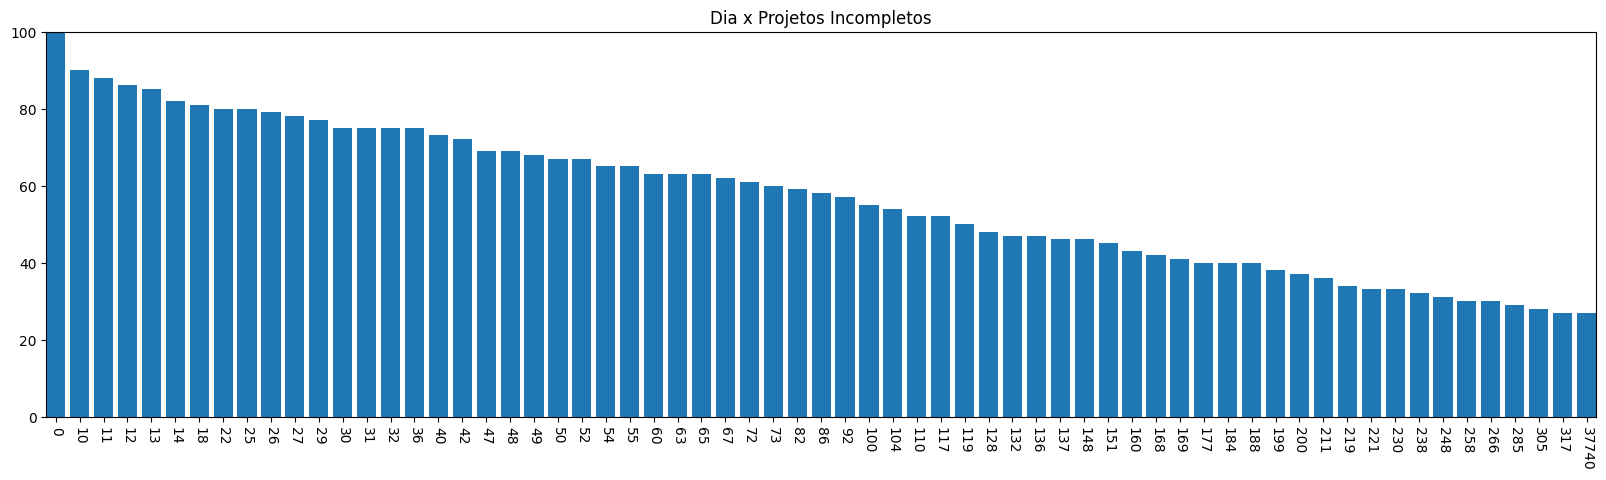

(27, 37740, 'B', 'Nearest', 'SPT', 800991)


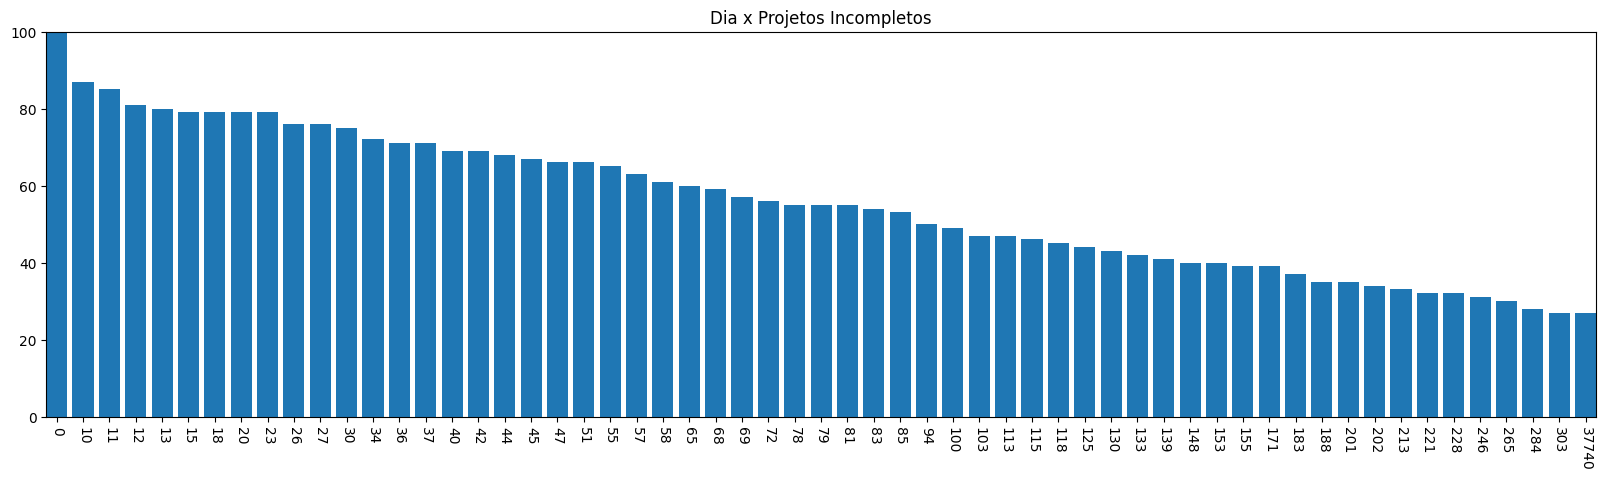

(28, 37740, 'B', 'Farest', 'SPT', 769472)


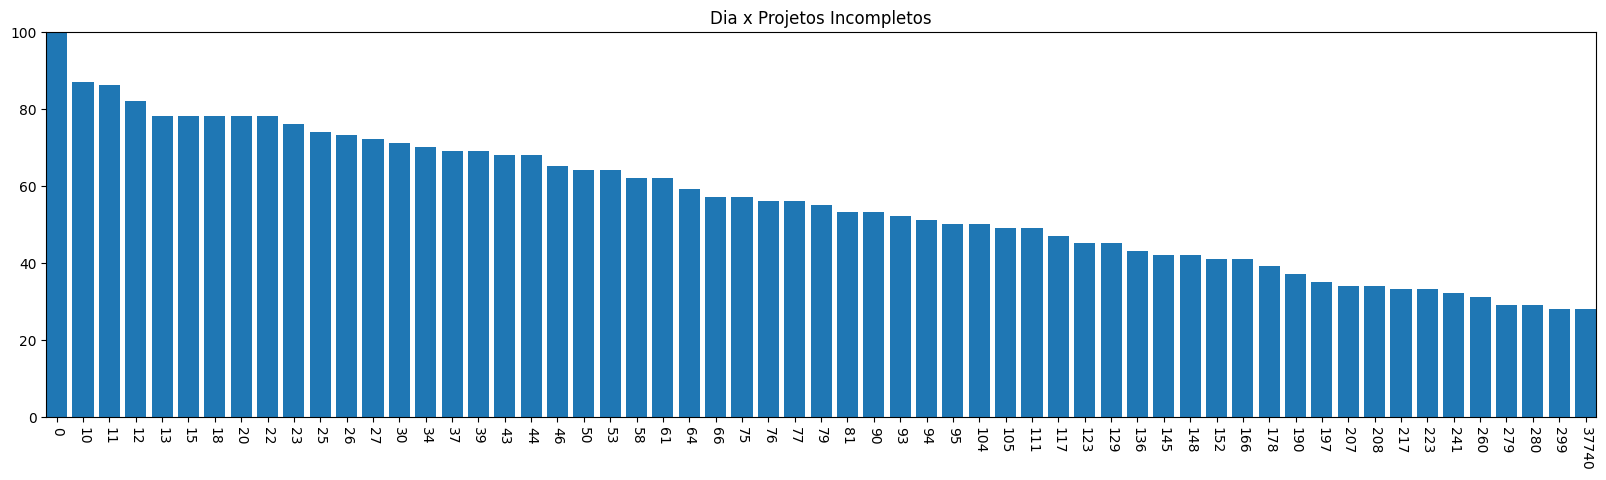

(27, 37740, 'B', 'First_to_find', 'LPT', 800991)


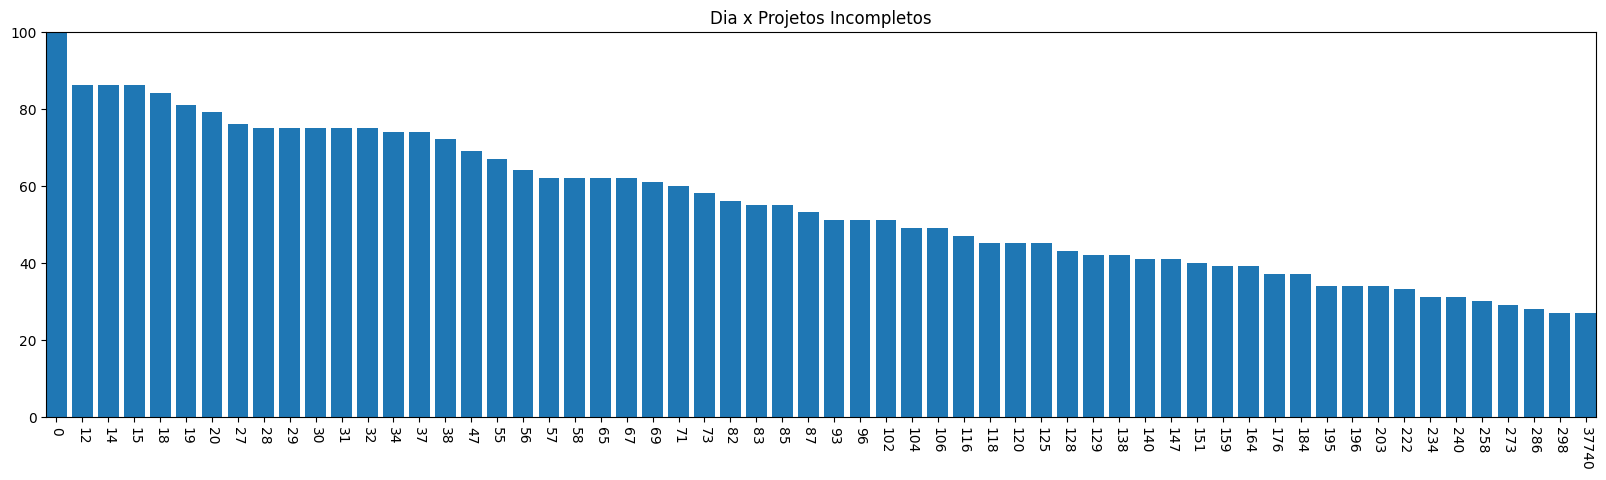

(28, 37740, 'B', 'Nearest', 'LPT', 769472)


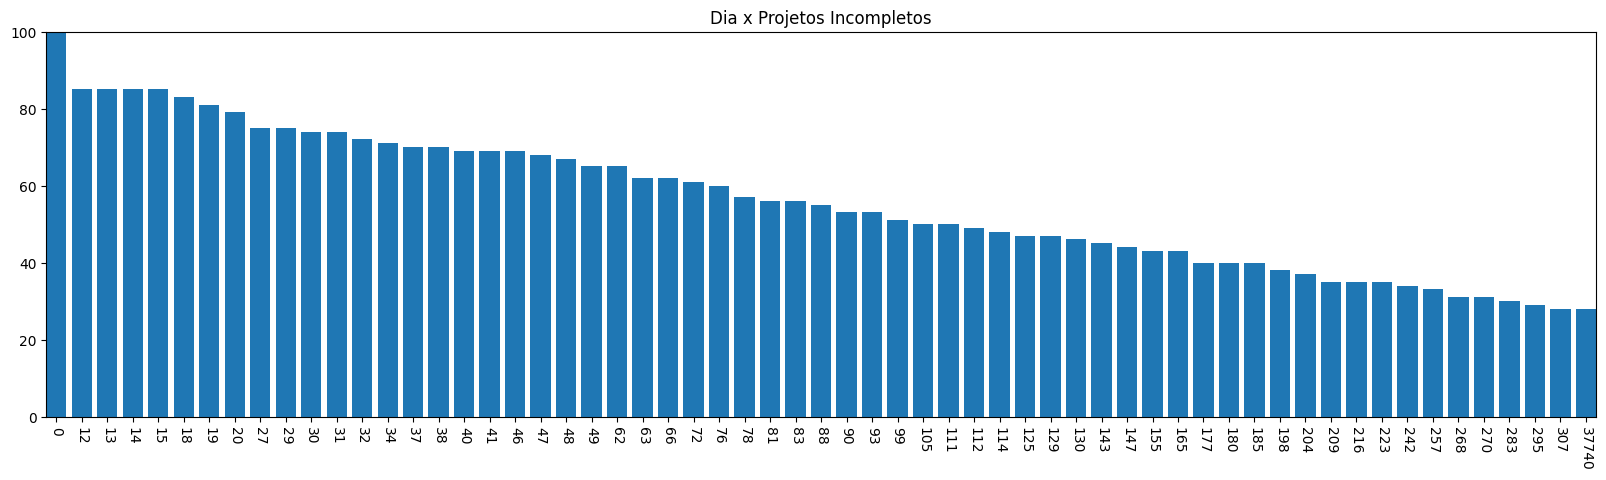

(29, 37740, 'B', 'Farest', 'LPT', 756975)


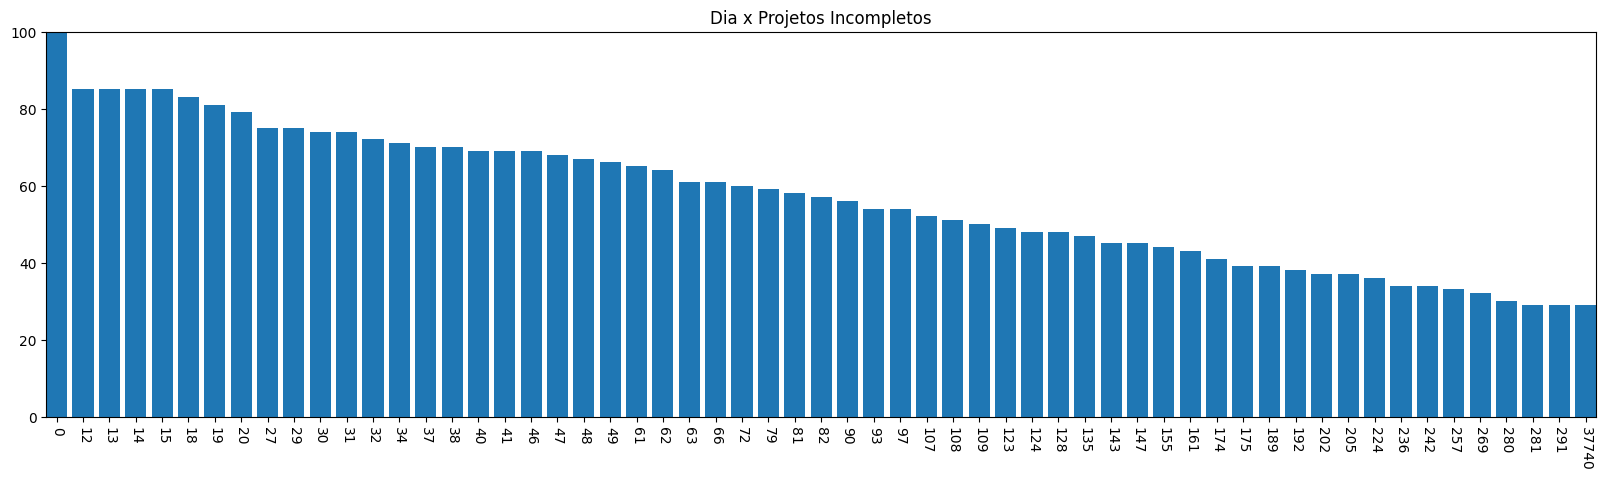

(27, 37740, 'B', 'First_to_find', 'EDD', 800991)


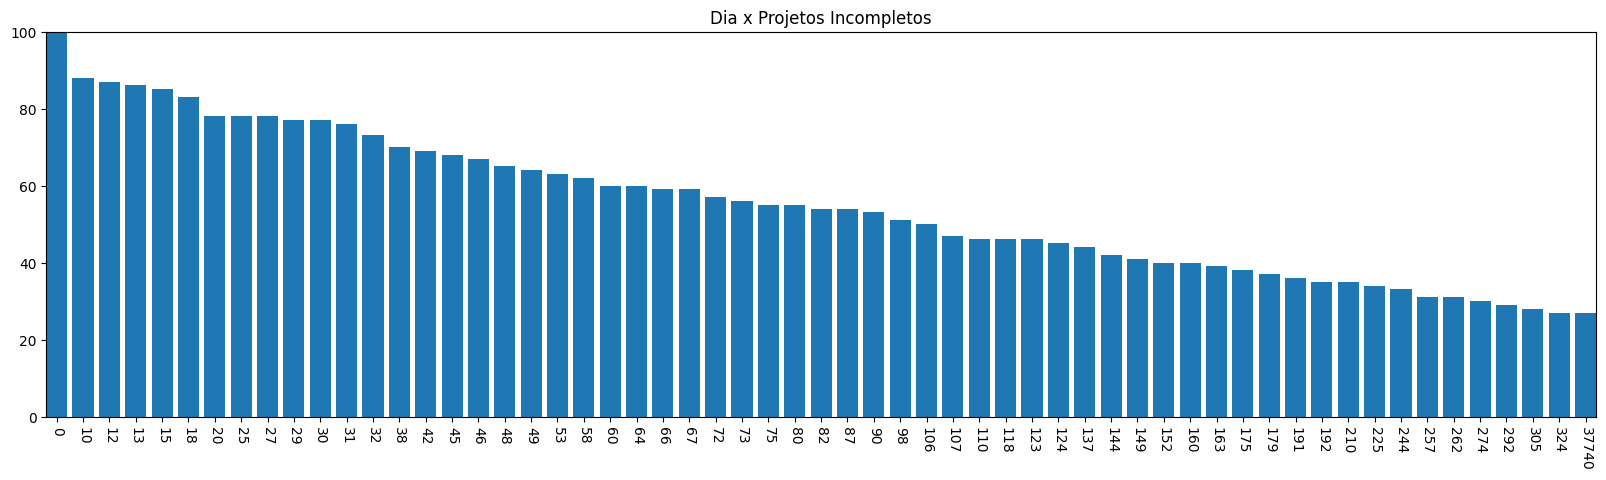

(26, 37740, 'B', 'Nearest', 'EDD', 802646)


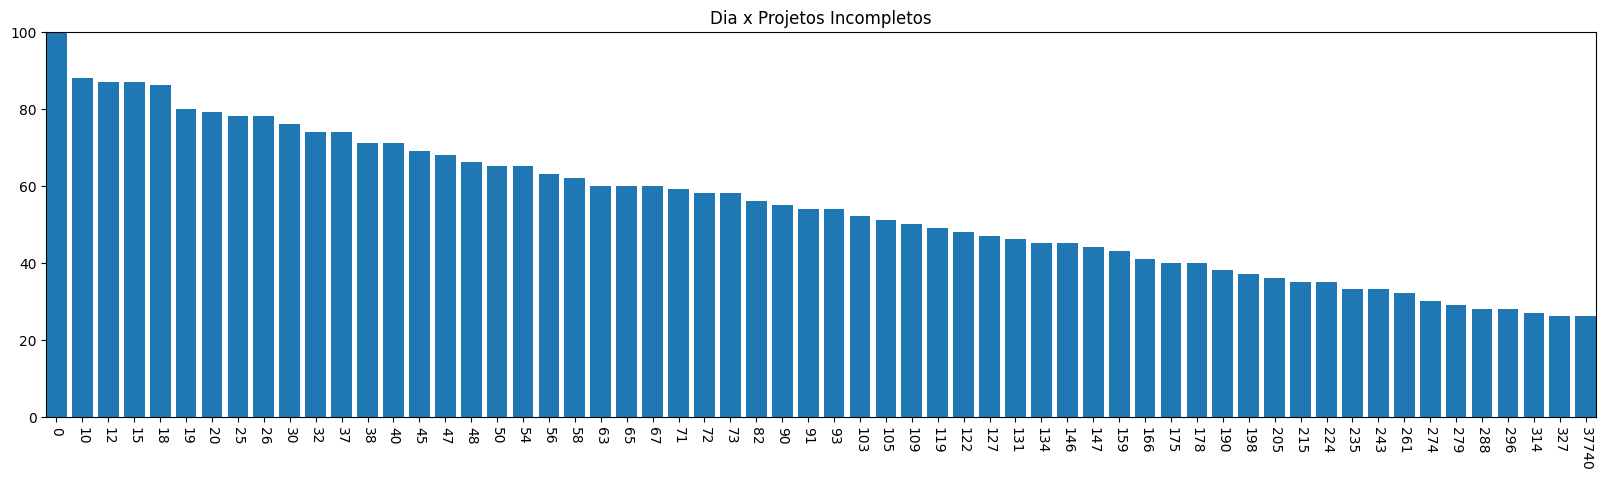

(24, 37740, 'B', 'Farest', 'EDD', 855630)


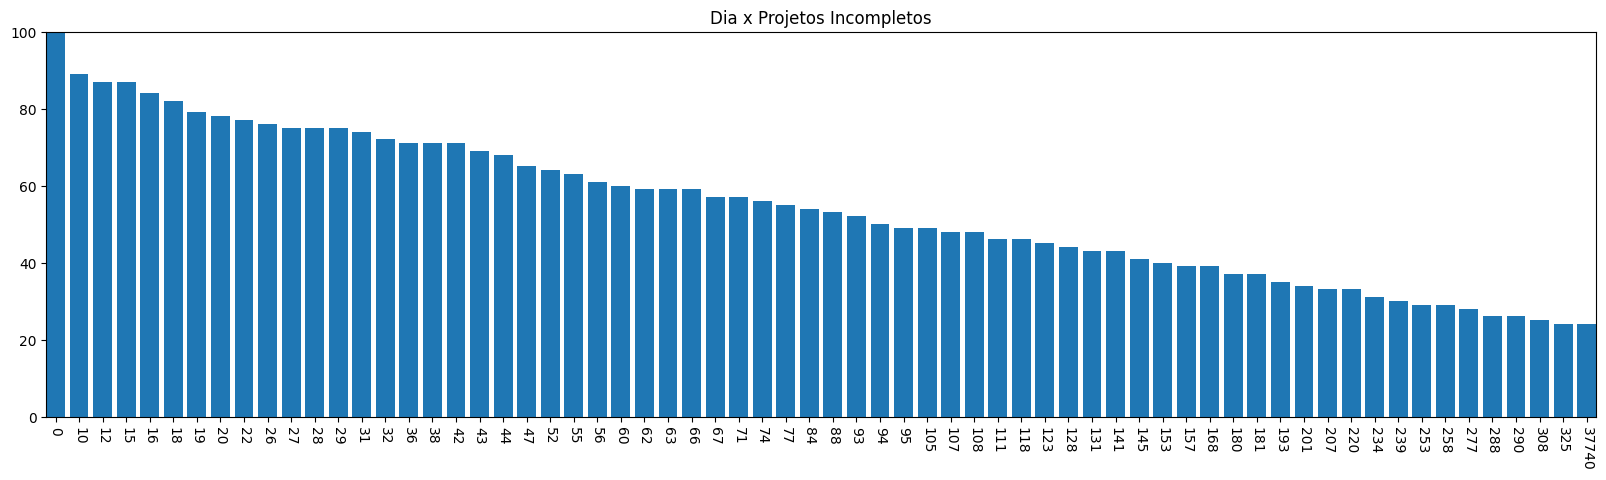

(24, 37740, 'B', 'First_to_find', 'MST', 855630)


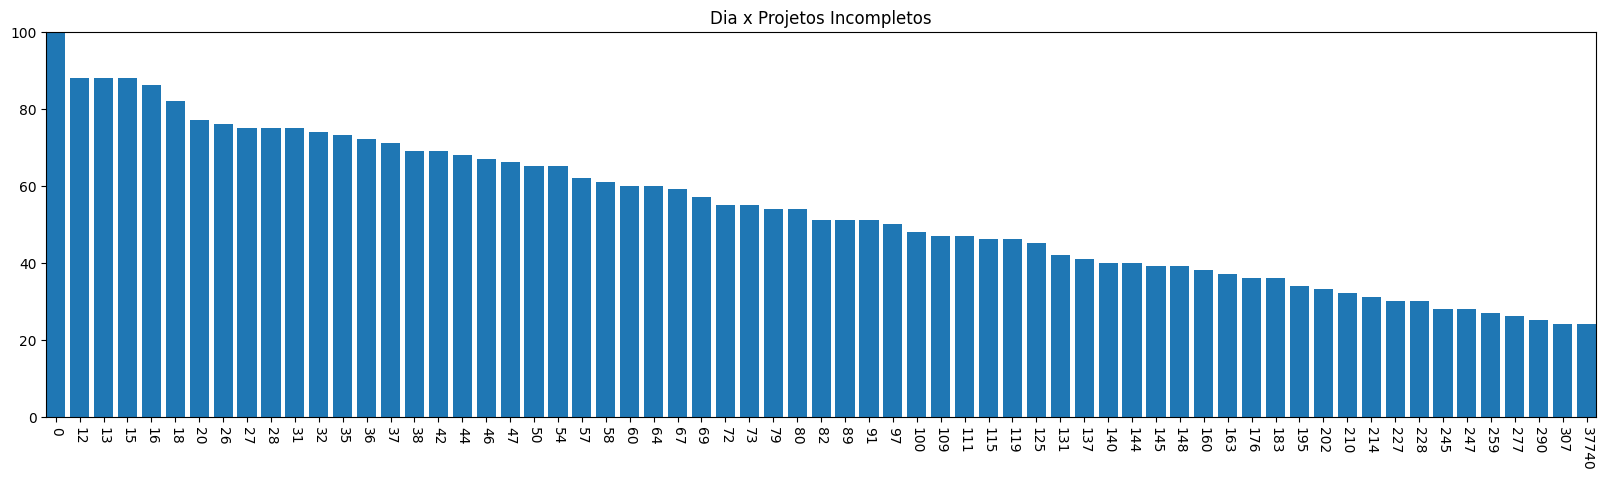

(24, 37740, 'B', 'Nearest', 'MST', 855630)


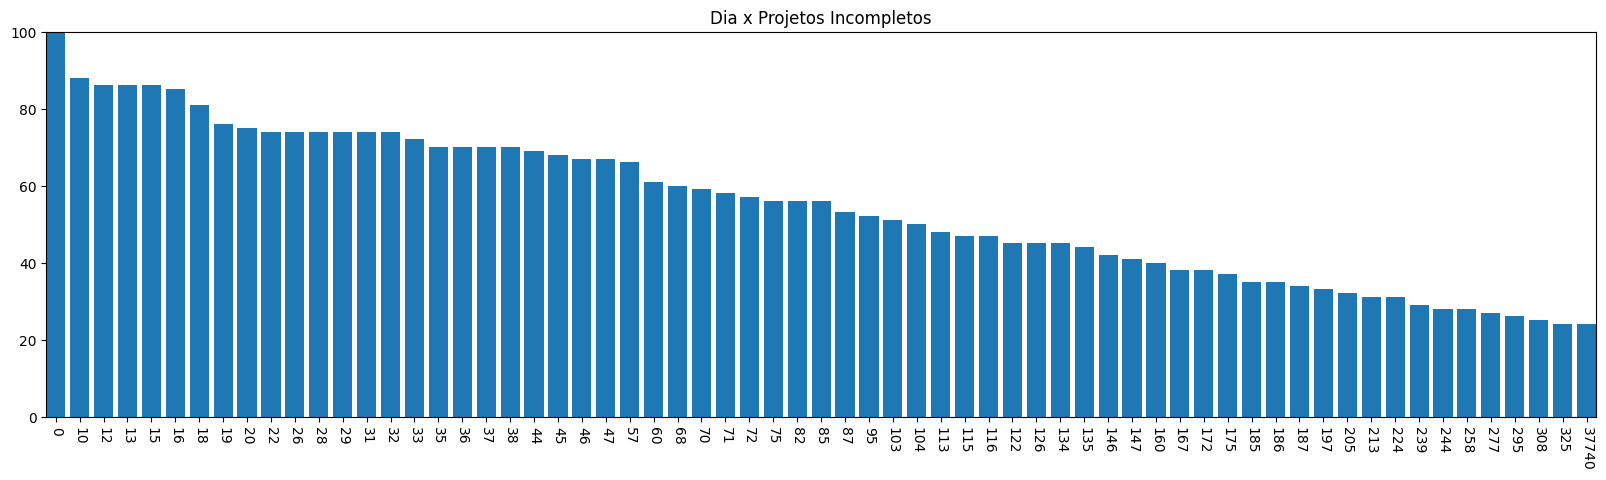

(24, 37740, 'B', 'Farest', 'MST', 855630)


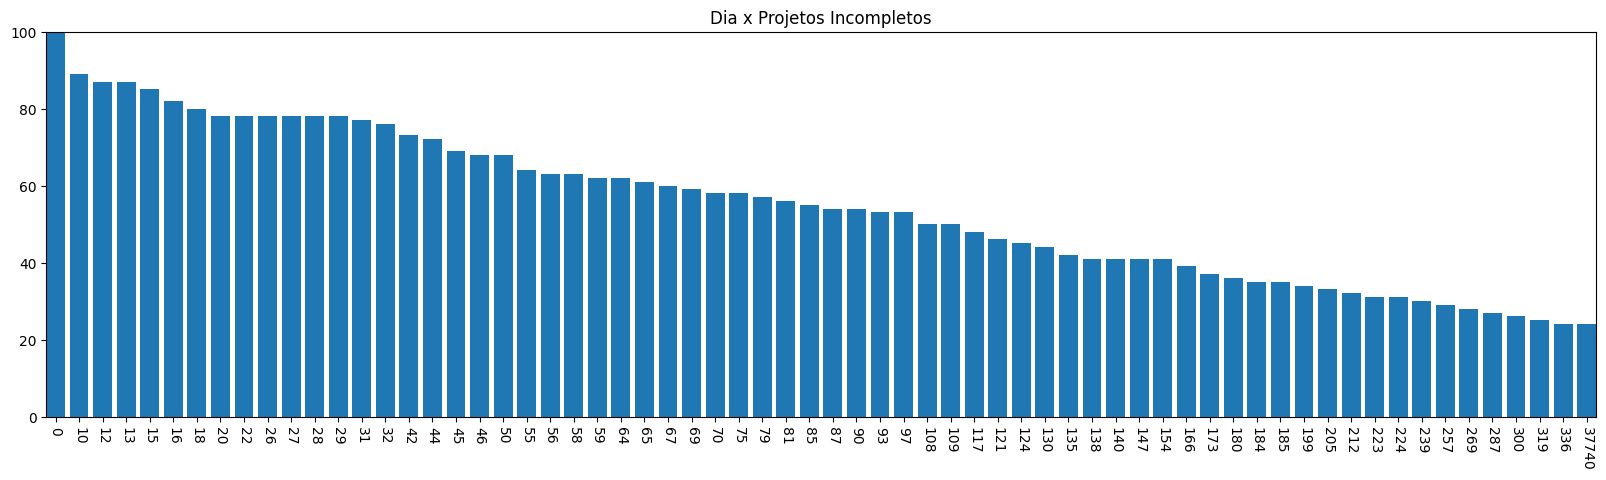

(24, 37740, 'B', 'First_to_find', 'CR', 855630)


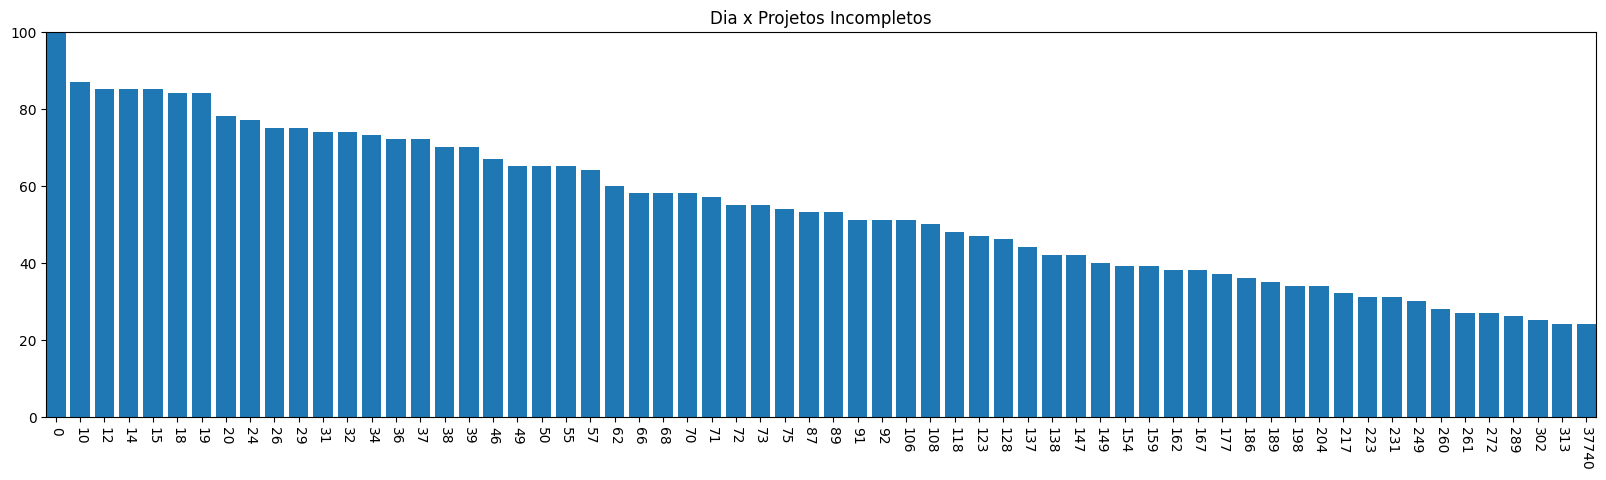

(25, 37740, 'B', 'Nearest', 'CR', 843157)


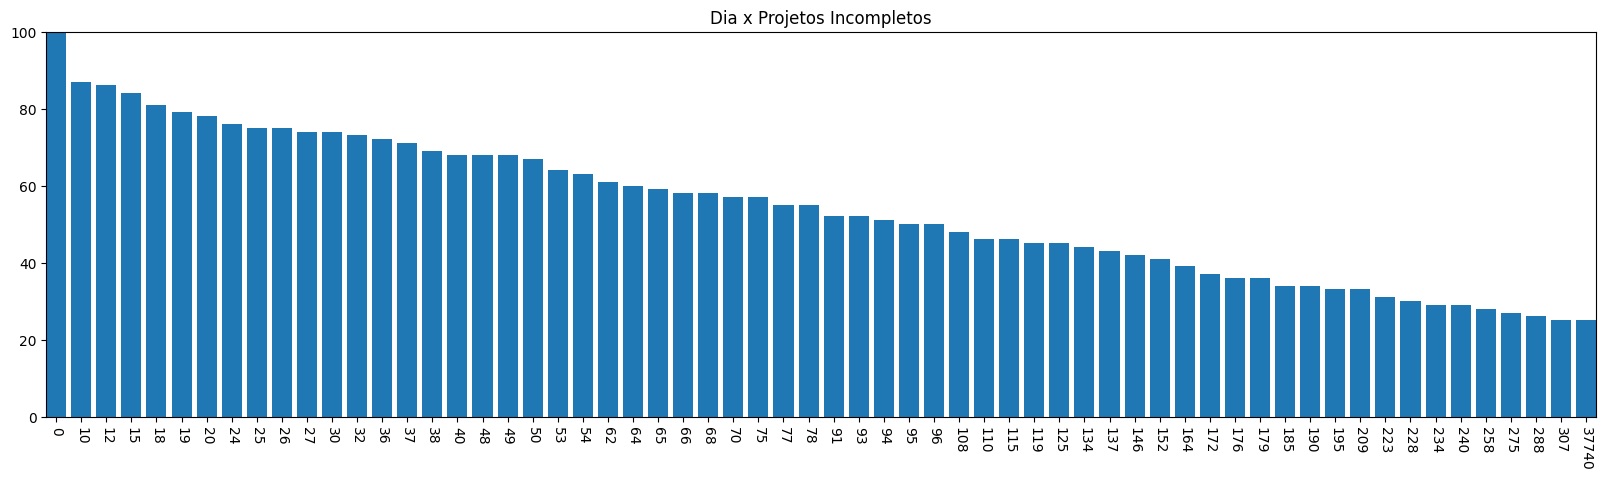

(25, 37740, 'B', 'Farest', 'CR', 843133)


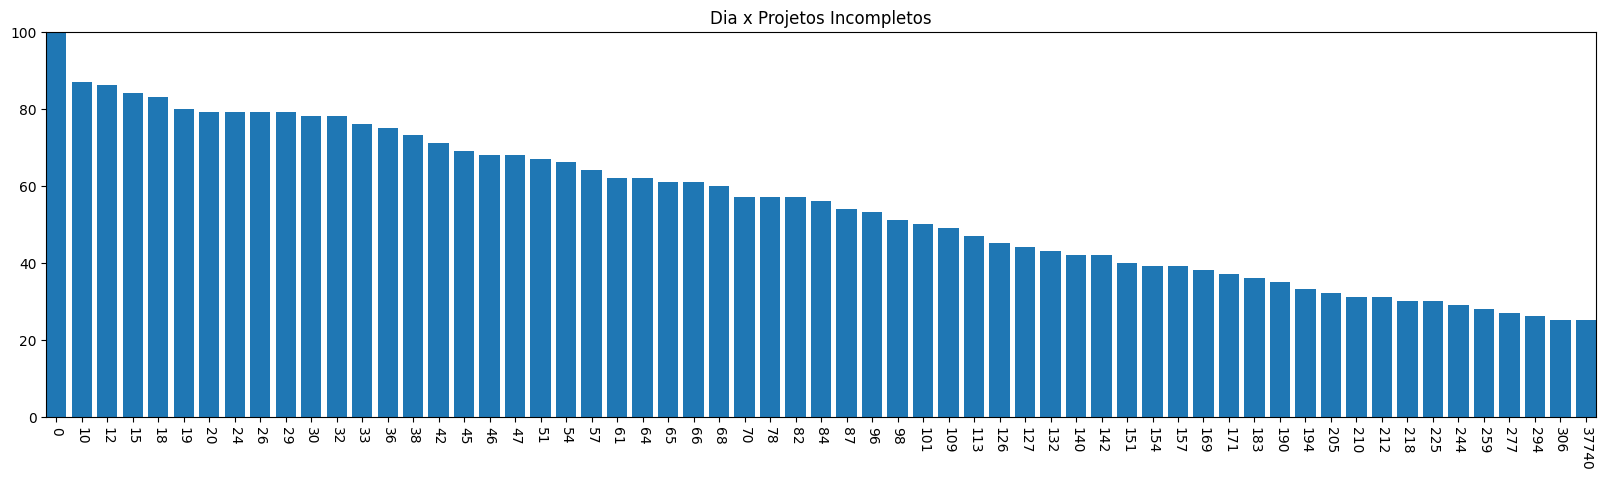

(24, 37740, 'B', 'First_to_find', 'SLACK', 855630)


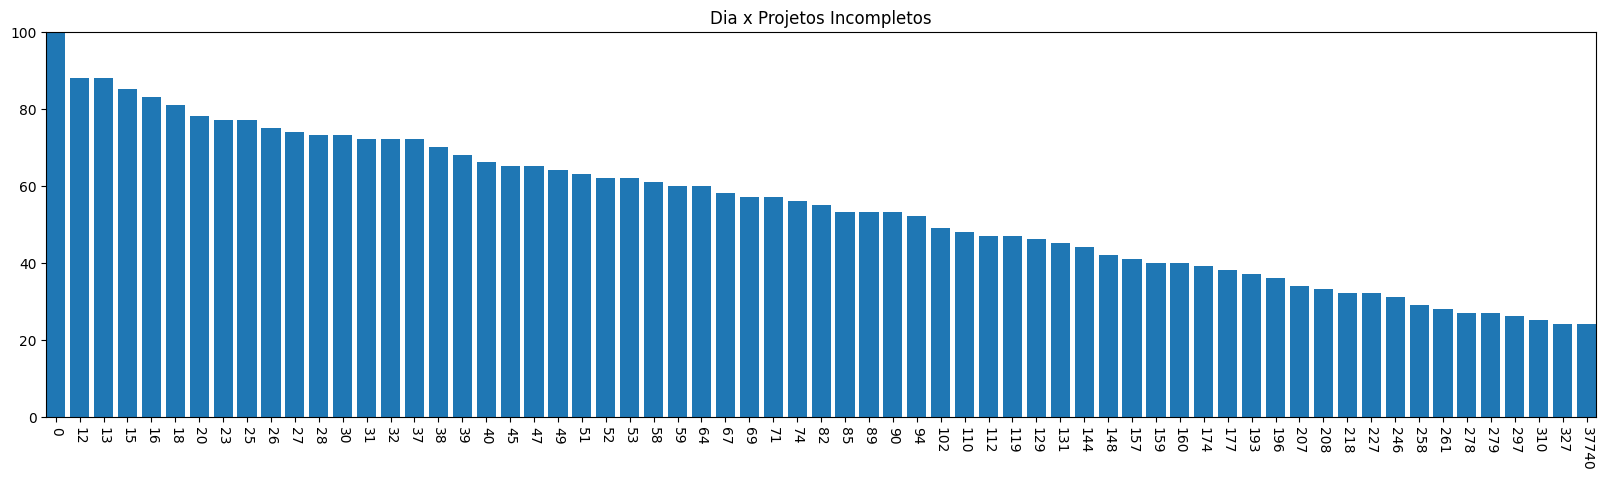

(25, 37740, 'B', 'Nearest', 'SLACK', 843157)


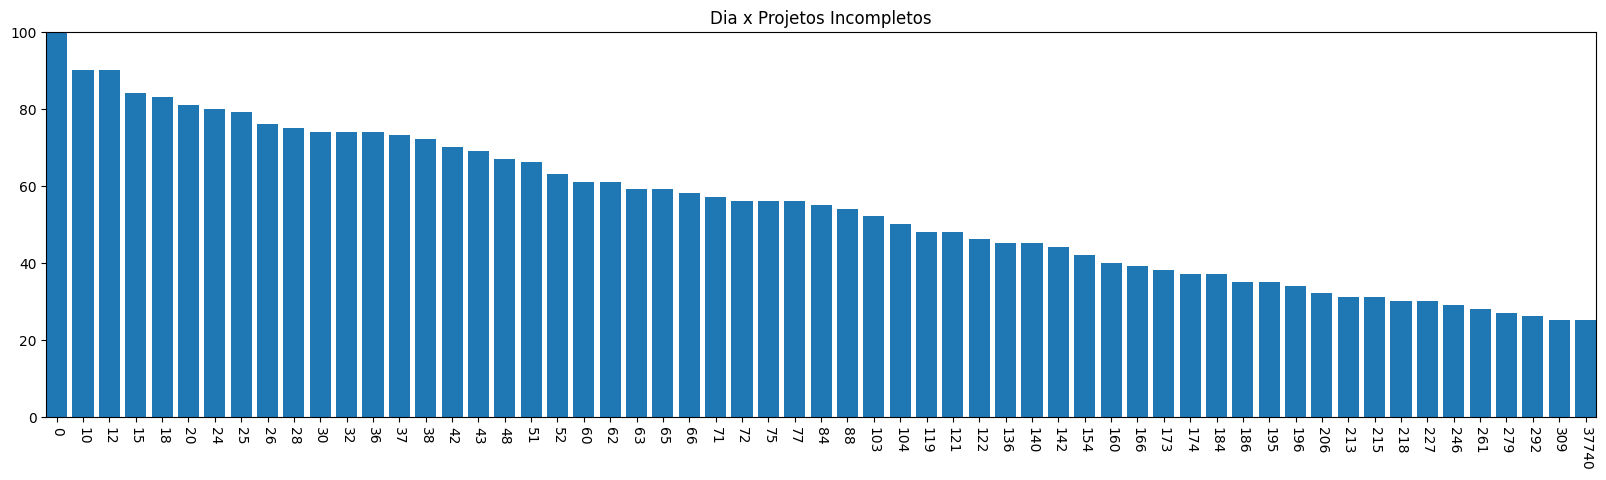

(26, 37740, 'B', 'Farest', 'SLACK', 821692)


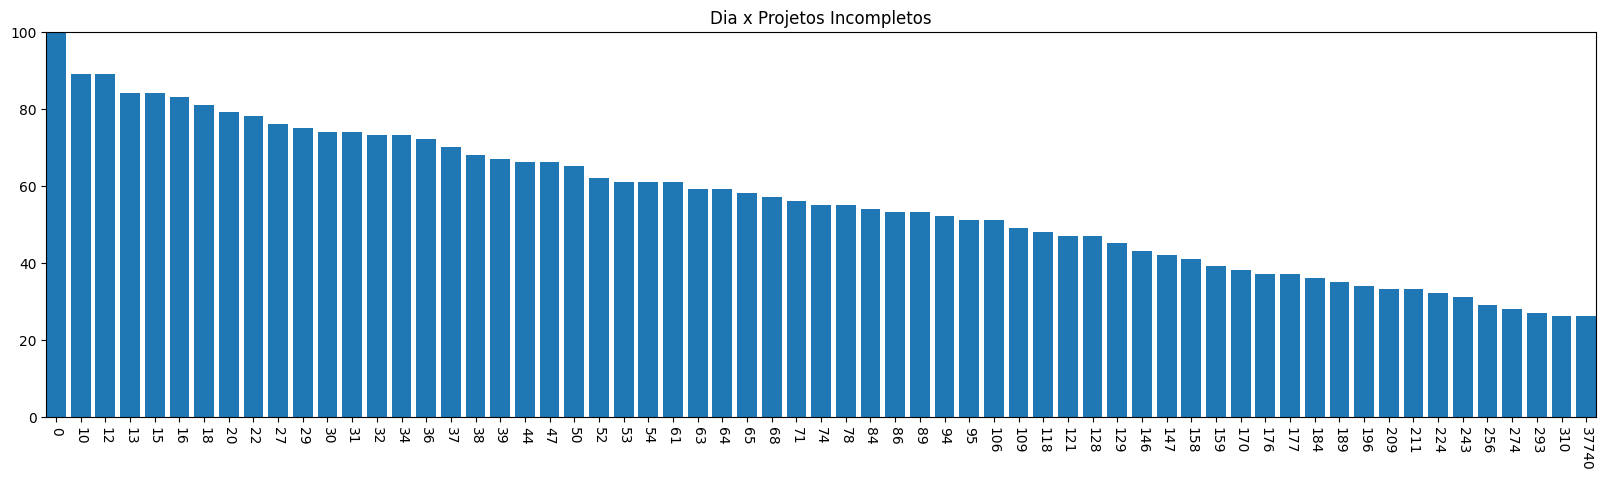

(24, 37740, 'B', 'First_to_find', 'MANPOWER', 855630)


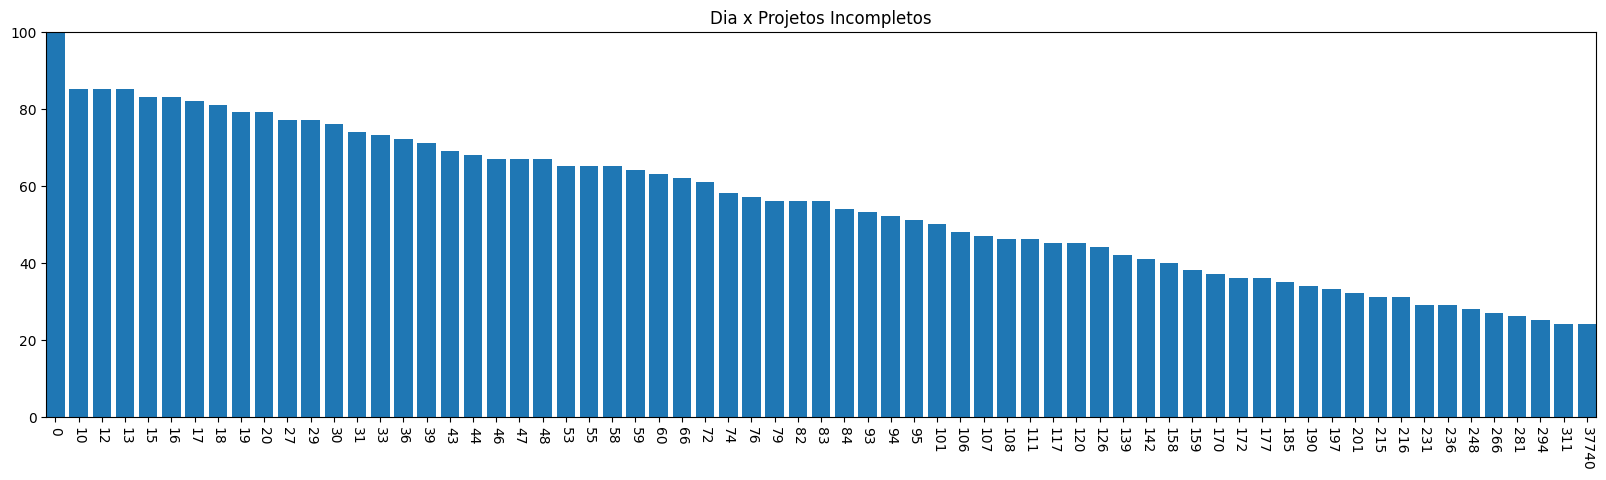

(25, 37740, 'B', 'Nearest', 'MANPOWER', 843157)


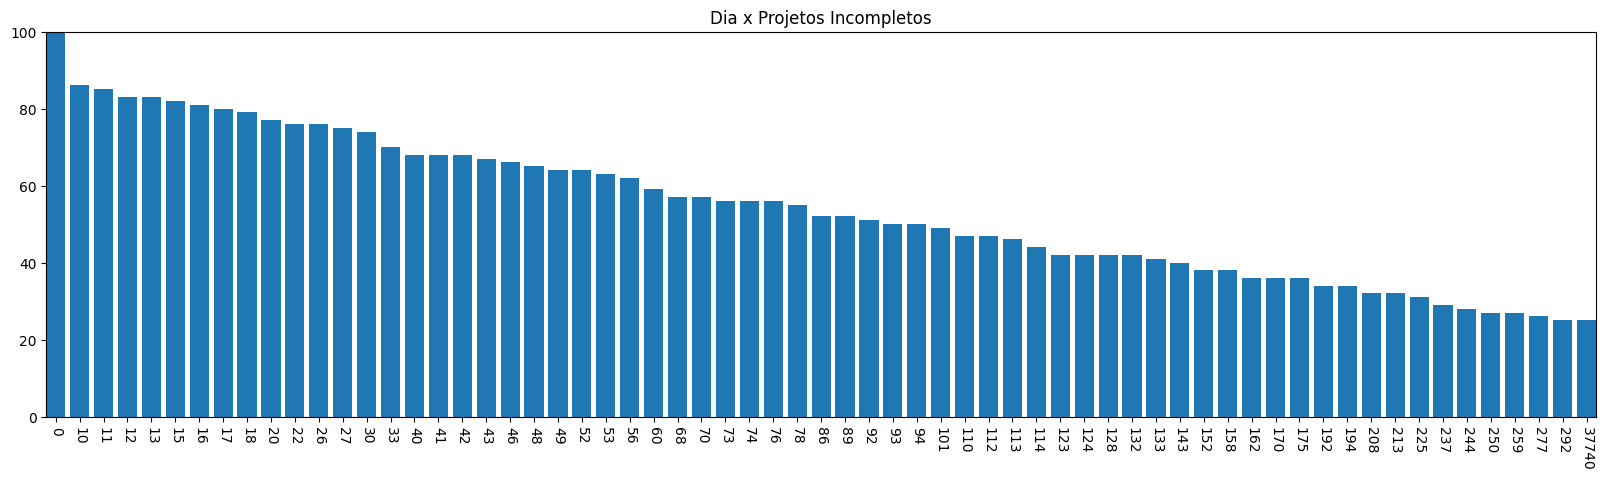

(25, 37740, 'B', 'Farest', 'MANPOWER', 828607)


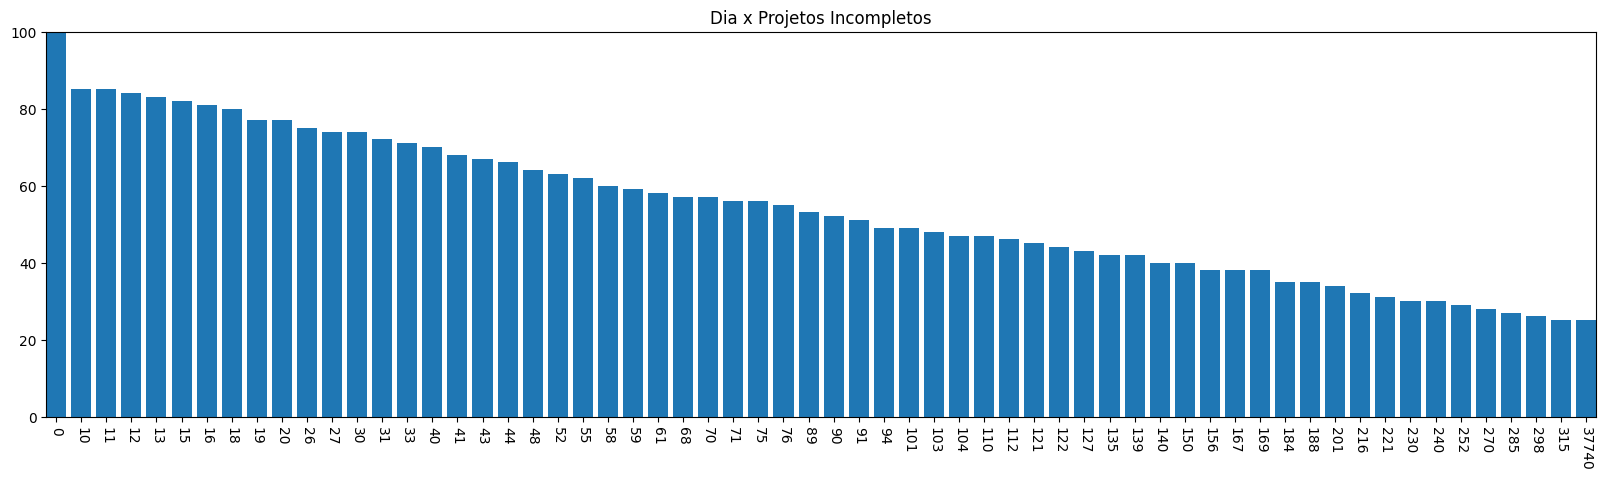

In [ ]:
dataset_B = read_dataset(dataset_b)
datasets = [ dataset_B]
instance = [ "B" ]

solutions = []
scores = []

priority_order = [ "SPT", "LPT", "EDD", "MST", "CR", "SLACK", "MANPOWER"]

contributor_order = [ "First_to_find", "Nearest", "Farest"]

# for data, PO in zip(datasets, priority_order, strict=False):
for i in range(len(instance)):
  for j in priority_order:
    for k in contributor_order:
      ip, maxd, solution,totalScore, plotx, ploty = solve(datasets[i], j, k, flag_print=0)
      solutions.append((ip, maxd, instance[i], k, j, totalScore))
      print((ip, maxd, instance[i], k, j, totalScore))
      imprime(plotx, ploty)

#for i in solutions:
#  print(i)

In [ ]:
dataset_C = read_dataset(dataset_c)
datasets = [ dataset_C]
instance = [ "C" ]

solutions = []
scores = []

priority_order = [ "SPT", "LPT", "EDD", "MST", "CR", "SLACK", "MANPOWER"]

contributor_order = [ "First_to_find", "Nearest", "Farest"]

# for data, PO in zip(datasets, priority_order, strict=False):
for i in range(len(instance)):
  break
  for j in priority_order:
    for k in contributor_order:
      ip, maxd, a,b, = solve(datasets[i], j, k)
      solutions.append((ip, maxd, instance[i], k, j, b))


for i in solutions:
  print(i)

In [ ]:
datasets = [ dataset_A, dataset_B, dataset_C, dataset_D, dataset_E, dataset_F]

for data in datasets:
  print(max(proj['bestBefore'] + proj['score'] for proj in data['projects'].values()))

40
37740
133826
15497
50979
54614


In [ ]:

datasets = [ dataset_A]
instance = [ "A" ]

solutions = []
scores = []

priority_order = [ "SPT", "LPT", "EDD", "MST", "CR", "SLACK", "MANPOWER"]

contributor_order = [ "First_to_find", "Nearest", "Farest"]

# for data, PO in zip(datasets, priority_order, strict=False):
for i in range(len(instance)):
  for j in priority_order:
    for k in contributor_order:
      ip, maxd, solution,totalScore, plotx, ploty = solve(datasets[i], j, k, flag_print=0)
      solutions.append((ip, maxd, instance[i], k, j, totalScore))
      print((ip, maxd, instance[i], k, j, totalScore))


(0, 40, 'A', 'First_to_find', 'SPT', 33)
(1, 40, 'A', 'Nearest', 'SPT', 30)
(1, 40, 'A', 'Farest', 'SPT', 30)
(1, 40, 'A', 'First_to_find', 'LPT', 30)
(1, 40, 'A', 'Nearest', 'LPT', 30)
(1, 40, 'A', 'Farest', 'LPT', 30)
(1, 40, 'A', 'First_to_find', 'EDD', 30)
(1, 40, 'A', 'Nearest', 'EDD', 30)
(1, 40, 'A', 'Farest', 'EDD', 30)
(1, 40, 'A', 'First_to_find', 'MST', 30)
(1, 40, 'A', 'Nearest', 'MST', 30)
(1, 40, 'A', 'Farest', 'MST', 30)
(1, 40, 'A', 'First_to_find', 'CR', 30)
(1, 40, 'A', 'Nearest', 'CR', 30)
(1, 40, 'A', 'Farest', 'CR', 30)
(1, 40, 'A', 'First_to_find', 'SLACK', 30)
(1, 40, 'A', 'Nearest', 'SLACK', 30)
(1, 40, 'A', 'Farest', 'SLACK', 30)
(0, 40, 'A', 'First_to_find', 'MANPOWER', 33)
(0, 40, 'A', 'Nearest', 'MANPOWER', 33)
(0, 40, 'A', 'Farest', 'MANPOWER', 33)
